In [131]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from umap import UMAP

%matplotlib inline

In [108]:
df = pd.read_csv("../datas/prepared/final_dataset_with_omdb.csv", index_col=0, encoding="ISO-8859-1")

In [109]:
df[df.columns[:-50]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, tt0003037 to tt7889682
Data columns (total 67 columns):
primaryTitle      27406 non-null object
originalTitle     27406 non-null object
startYear         27406 non-null float64
runtimeMinutes    27406 non-null int64
averageRating     27406 non-null float64
numVotes          27406 non-null int64
Action            27406 non-null int64
Adventure         27406 non-null int64
Animation         27406 non-null int64
Biography         27406 non-null int64
Comedy            27406 non-null int64
Crime             27406 non-null int64
Drama             27406 non-null int64
Family            27406 non-null int64
Fantasy           27406 non-null int64
Film-Noir         27406 non-null int64
History           27406 non-null int64
Horror            27406 non-null int64
Musical           27406 non-null int64
Mystery           27406 non-null int64
Romance           27406 non-null int64
Sci-Fi            27406 non-null int64
Sport             27

In [110]:
df[df.columns[-50:]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 27406 entries, tt0003037 to tt7889682
Data columns (total 50 columns):
France            27406 non-null int64
Germany           27406 non-null int64
Hong Kong         27406 non-null int64
India             27406 non-null int64
Italy             27406 non-null int64
Japan             27406 non-null int64
Mexico            27406 non-null int64
Spain             27406 non-null int64
Sweden            27406 non-null int64
Turkey            27406 non-null int64
UK                27406 non-null int64
USA               27406 non-null int64
Lang_En           27406 non-null int64
Lang_Fr           27406 non-null int64
Topic_0           27406 non-null float64
Topic_1           27406 non-null float64
Topic_2           27406 non-null float64
Topic_3           27406 non-null float64
Topic_4           27406 non-null float64
Topic_5           27406 non-null float64
Topic_6           27406 non-null float64
Topic_7           27406 non-null float64
Topic_8   

# Required Scaling

Move to log for too big scale

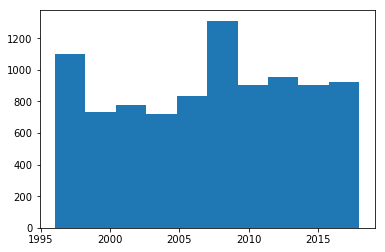

In [121]:
plt.hist(df.startYear)
plt.show()

In [112]:
avg_duration = df[df.runtimeMinutes < 1000].runtimeMinutes.mean()

In [114]:
df.loc[df.runtimeMinutes > 1000, "runtimeMinutes"] = avg_duration

In [117]:
df.numVotes = np.log(df.numVotes)

In [118]:
df.BoxOffice = df.BoxOffice.fillna(1)
df.BoxOffice = np.log(df.BoxOffice)

In [119]:
# a movie with 10 oscar is not 10 times better than a movie with 1 oscar, so a log is also a good but log(n+1) as lot of movies have 0 rewards

df.oscar_won = np.log(df.oscar_won + 1)
df.oscar_nom = np.log(df.oscar_nom + 1)
df.gg_won = np.log(df.gg_won + 1)
df.gg_nom = np.log(df.gg_nom + 1)
df.bafta_won = np.log(df.bafta_won + 1)
df.bafta_nom = np.log(df.bafta_nom + 1)
df.other_win = np.log(df.other_win + 1)
df.other_nom = np.log(df.other_nom + 1)

In [120]:
df = df[df.startYear > 1995]

In [122]:
X = df.drop(["primaryTitle", "originalTitle"], axis=1)

In [123]:
X["startYear"] = MinMaxScaler().fit_transform(X[["startYear"]])
X["averageRating"] = MinMaxScaler().fit_transform(X[["averageRating"]])
X["Metascore"] = MinMaxScaler().fit_transform(X[["Metascore"]])
X["Score_RT"] = MinMaxScaler().fit_transform(X[["Score_RT"]])

X["runtimeMinutes"] = StandardScaler().fit_transform(X[["runtimeMinutes"]])
X["numVotes"] = StandardScaler().fit_transform(X[["numVotes"]])
X["BoxOffice"] = StandardScaler().fit_transform(X[["BoxOffice"]])

X["oscar_won"] = MinMaxScaler().fit_transform(X[["oscar_won"]])
X["oscar_nom"] = MinMaxScaler().fit_transform(X[["oscar_nom"]])
X["gg_won"] = MinMaxScaler().fit_transform(X[["gg_won"]])
X["gg_nom"] = MinMaxScaler().fit_transform(X[["gg_nom"]])
X["bafta_won"] = MinMaxScaler().fit_transform(X[["bafta_won"]])
X["bafta_nom"] = MinMaxScaler().fit_transform(X[["bafta_nom"]])
X["other_win"] = MinMaxScaler().fit_transform(X[["other_win"]])
X["other_nom"] = MinMaxScaler().fit_transform(X[["other_nom"]])

for col in df:
    if col.startswith("Topic_"):
        X[col] = MinMaxScaler().fit_transform(X[[col]])

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9150 entries, tt0035423 to tt7889682
Columns: 117 entries, primaryTitle to prod_Paramount
dtypes: float64(35), int64(80), object(2)
memory usage: 8.2+ MB


# UMAP

In [132]:
model = UMAP(metric="euclidean", 
             n_neighbors=20, 
             n_components=3
            )
pos = model.fit_transform(X)

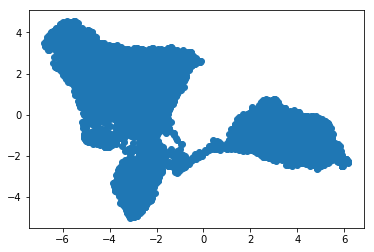

In [129]:
plt.scatter(pos[:,0], pos[:,1])
plt.show()

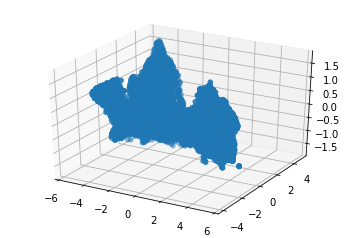

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:,0], pos[:,1], pos[:,2])
plt.show()

In [96]:
# df = df[pos[:,1]>=-9]  # group found with multiple test, old movies, unknown and with low ranking
# X = X[pos[:,1]>=-9] 

In [130]:
df[(pos[:,0]>12) & (pos[:,1]>-1)]  

,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,Action,Adventure,Animation,Biography,...,prod_WB,prod_Sony,prod_VCI,prod_Disney,prod_Indep,prod_MGM,prod_Fox,prod_Universal,prod_Lion,prod_Paramount
tconst,,,,,,,,,,,,,,,,,,,,,


In [127]:
df[pos[:,0]<-15]

,primaryTitle,originalTitle,startYear,runtimeMinutes,averageRating,numVotes,Action,Adventure,Animation,Biography,...,prod_WB,prod_Sony,prod_VCI,prod_Disney,prod_Indep,prod_MGM,prod_Fox,prod_Universal,prod_Lion,prod_Paramount
tconst,,,,,,,,,,,,,,,,,,,,,
tt0241527,Harry Potter and the Sorcerer's Stone,Harry Potter and the Sorcerer's Stone,2001.0,152.0,7.6,13.159200,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0295297,Harry Potter and the Chamber of Secrets,Harry Potter and the Chamber of Secrets,2002.0,161.0,7.4,13.014845,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0304141,Harry Potter and the Prisoner of Azkaban,Harry Potter and the Prisoner of Azkaban,2004.0,142.0,7.8,13.003987,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0330373,Harry Potter and the Goblet of Fire,Harry Potter and the Goblet of Fire,2005.0,157.0,7.7,13.007024,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0373889,Harry Potter and the Order of the Phoenix,Harry Potter and the Order of the Phoenix,2007.0,138.0,7.5,12.929288,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0417741,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince,2009.0,153.0,7.6,12.841283,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0926084,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1,2010.0,146.0,7.7,12.859223,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
tt1201607,Harry Potter and the Deathly Hallows: Part 2,Harry Potter and the Deathly Hallows: Part 2,2011.0,130.0,8.1,13.360482,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# TSNE

In [134]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, 
                  perplexity=30.0, 
                  early_exaggeration=12.0, 
                  learning_rate=200.0, 
                  n_iter=1000, 
                  n_iter_without_progress=300, 
                  min_grad_norm=1e-07, 
                  metric="euclidean", 
                  init="random", 
                  verbose=0, 
                  random_state=None, 
                  method="barnes_hut", 
                  angle=0.5
                 ).fit_transform(X)

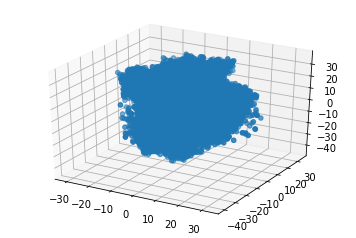

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2])
plt.show()

In [137]:
X_embedded.shape

(9150, 3)

In [142]:
to_save = df[["primaryTitle"]].reset_index()

In [148]:
to_save["score"] = df.averageRating.values * df.numVotes.values

In [152]:
pos = pd.DataFrame(X_embedded)
pos.columns = ["X", "Y", "Z"]

In [155]:
end = pd.concat([to_save, pos], axis=1).sort_values(by=['score'], ascending = False).reset_index(drop=True)

In [157]:
end.to_json("new_model.json")

In [158]:
end

,tconst,primaryTitle,score,X,Y,Z
0,tt0468569,The Dark Knight,130.116616,9.939671,22.579901,29.813513
1,tt0167260,The Lord of the Rings: The Return of the King,125.806130,9.623456,24.936787,30.629610
2,tt0137523,Fight Club,125.403171,28.317802,5.137299,16.393114
3,tt0120737,The Lord of the Rings: The Fellowship of the Ring,124.516133,9.425447,24.569088,30.330765
4,tt0133093,The Matrix,123.033620,28.567339,5.201569,16.890789
5,tt0167261,The Lord of the Rings: The Two Towers,122.113481,9.415153,24.570734,30.304504
6,tt0816692,Interstellar,120.053823,9.145952,23.695210,30.669018
7,tt0120815,Saving Private Ryan,118.951789,27.192245,6.702063,16.109283
8,tt0172495,Gladiator,118.380915,27.393414,6.536981,17.088562
9,tt1345836,The Dark Knight Rises,118.203883,9.878126,22.764479,29.865856
